In [1]:
!pip install xmltodict

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import PIL
import cv2
import xmltodict
import random
from tqdm import tqdm
from PIL import ImageDraw
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [24]:
path = "training_images"

In [25]:
def normalize(path):
    images=[]
    names =[]
    for file in tqdm(glob.glob(path +"/*.jpg")):
        image = cv2.resize(cv2.imread(file), (228,228))
        image = np.array(image)
        name = file.split('/')[-1].split('_')[0]
        images.append(image)
        names.append(name)
    return images,names

In [26]:
images,names = normalize(path)

100%|██████████| 186/186 [00:00<00:00, 516.73it/s]


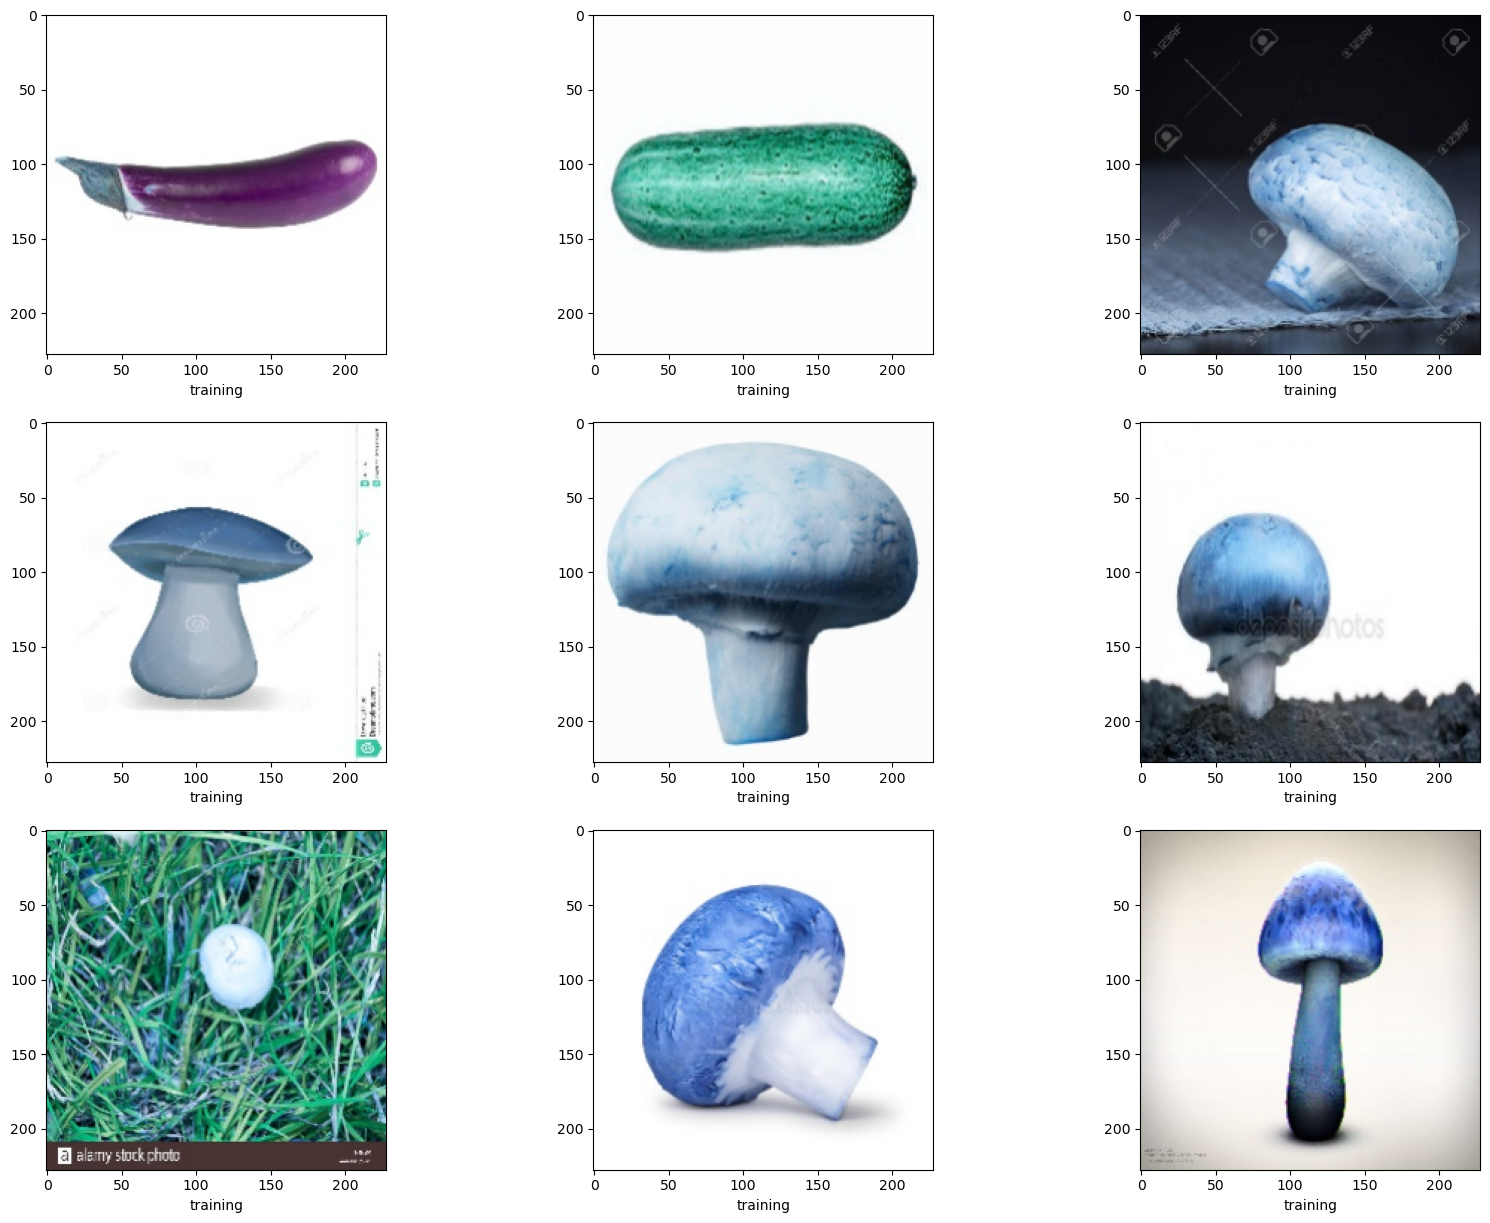

In [27]:
fig = plt.figure(figsize=(20,15))

for i in range(9):
    r = random.randint(1,186)
    plt.subplot(3,3,i+1)
    plt.imshow(images[r])
    plt.xlabel(names[r])
    
plt.show()

In [28]:
def get_bbox(xml_path):
    bboxes =[]
    classnames=[]
    for file in tqdm(glob.glob(xml_path + "/*.xml")):
        x = xmltodict.parse(open(file, 'rb'))
        bbox = x['annotation']['object']['bndbox']
        name = x['annotation']['object']['name']
        bbox = np.array([int(bbox['xmin']),int(bbox['ymin']),int(bbox['xmax']),int(bbox['ymax'])])
        bbox2 = [None]*4
        bbox2[0] = bbox[0]
        bbox2[1] = bbox[1]
        bbox2[2] = bbox[2]
        bbox2[3] = bbox[3]
        bbox2 = np.array(bbox2)/228
        bboxes.append(bbox2)
        classnames.append(name)
    return np.array(bboxes), classnames

In [29]:
bboxes, classnames = get_bbox(path)

100%|██████████| 186/186 [00:00<00:00, 1300.36it/s]


In [30]:
encoder = LabelBinarizer()
classnames = encoder.fit_transform(classnames)
Y = np.concatenate([bboxes, classnames], axis=1)
X = np.array(images)

In [70]:
import pickle
seri = pickle.dumps(encoder)

In [71]:
with open('file.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(encoder, file)

In [58]:
# with open(os.path.join(encoder,'labels'), 'wb') as f:
#     pickle.dump(lb, f)

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1)

In [32]:
def calculate_iou(target, pred):
    
    xA = K.maximum(target[:,0], pred[:,0])
    yA = K.maximum(target[:,1], pred[:,1])
    xB = K.minimum(target[:,2], pred[:,2])
    yB = K.minimum(target[:,3], pred[:,3])
    interArea = K.maximum(0.0, xB-xA)*K.maximum(0.0,yB-yA)
    boxAarea = (target[:,2]-target[:,0])*(target[:,3]-target[:,1])
    boxBarea = (pred[:,2]-pred[:,0]) * (pred[:,3]-pred[:,1])
    
    iou = interArea / (boxAarea+boxBarea - interArea)
    return iou


def custom_loss(y_true, y_pred):
    mse = tf.losses.mean_squared_error(y_true, y_pred)
    iou = calculate_iou(y_true , y_pred)
    return mse + (1-iou)

def iou_metric(y_true, y_pred):
    return calculate_iou(y_true, y_pred)

In [33]:
input_shape = ( 228 , 228 , 3 )
dropout_rate = 0.5
classes =3
alpha = 0.2
prediction_units = 4+ classes

In [34]:
def block1(filters,X):
    
    x = Conv2D(filters, kernel_size=(3,3), strides=1 )(X)
    x = LeakyReLU(alpha)(x)
    x = Conv2D(filters, (3,3), strides=1)(x)
    x = LeakyReLU(alpha)(x)
    x = MaxPool2D((2,2))(x)
    return x

def block2(units,X):
    
    x = Dense(units)(X)
    x = LeakyReLU(alpha)(x)    
    return x
    

In [35]:
def mymodel():
    
    model_input = Input(shape=(228,228,3))
    x= block1(16, model_input)
    x= block1(32,x)
    x = block1(64,x)
    x= block1(128,x)
    x = block1(256,x)
    
    x = Flatten()(x)
    x = block2(1240, x)
    x = block2(640, x)
    x = block2(480,x)
    x = block2(120,x)
    x = block2(62,x)
    model_outputs = Dense(prediction_units)(x)
    
    model = Model(inputs=[model_input], outputs=[model_outputs])
    
    model.compile( tf.keras.optimizers.Adam(0.0001),
                 loss=custom_loss,
                 metrics=[iou_metric])

#     model.compile( tf.keras.optimizers.Adam(0.0001),loss="mean_squared_error",
#                  metrics=[iou_metric])
    
    return model
    

In [36]:
model = mymodel()
#model.summary()

In [37]:
#plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [57]:
history = model.fit( 
    X_train ,
    Y_train , 
    validation_data=( X_test , Y_test ),
    epochs=2 ,
    batch_size=3
)

Epoch 1/2
56/56 [==============================] - 6s 84ms/step - loss: 0.8323 - iou_metric: 0.3372 - val_loss: 0.7018 - val_iou_metric: 0.4118
Epoch 2/2
56/56 [==============================] - 4s 76ms/step - loss: 0.6327 - iou_metric: 0.4668 - val_loss: 0.5990 - val_iou_metric: 0.4955


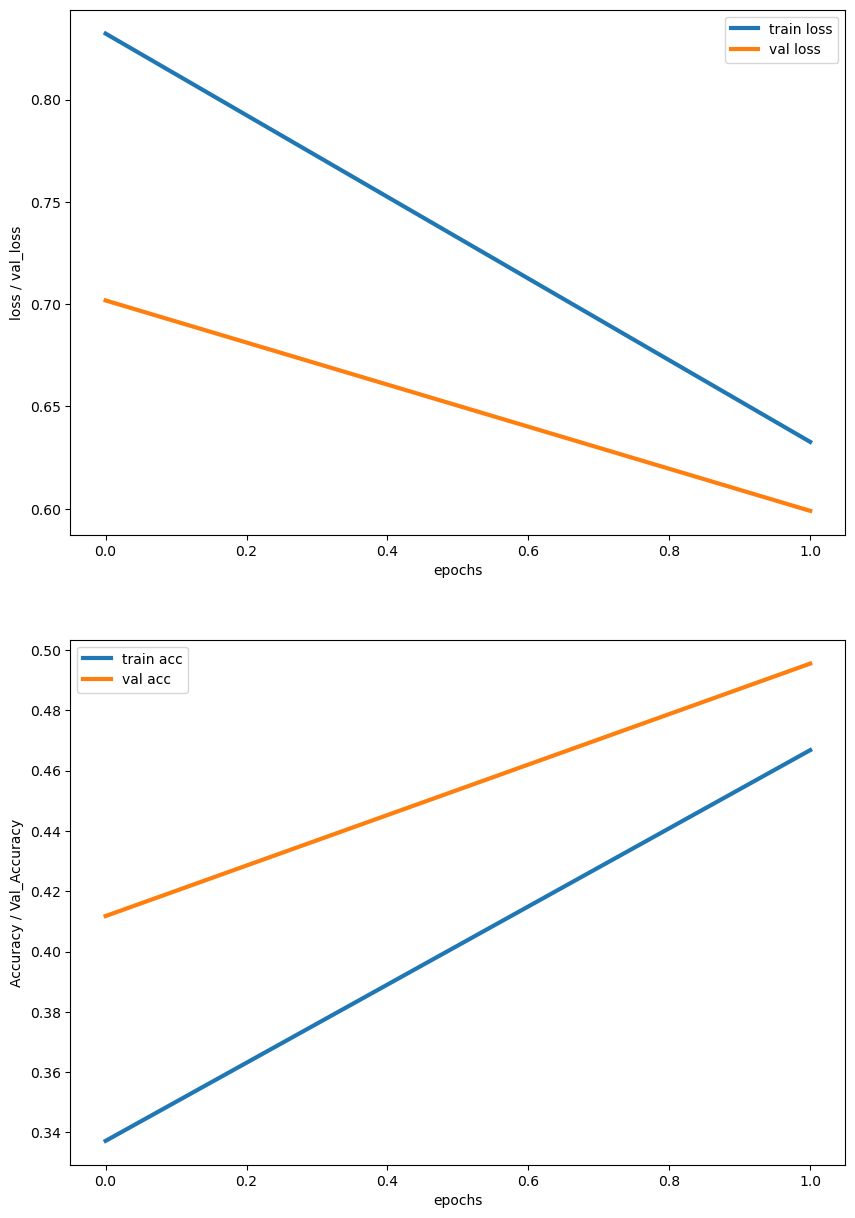

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['iou_metric']
val_acc = history.history['val_iou_metric']


plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(loss , linewidth=3 ,label='train loss')
plt.plot(val_loss , linewidth=3, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss / val_loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(acc , linewidth=3 ,label='train acc')
plt.plot(val_acc , linewidth=3, label='val acc')
plt.xlabel('epochs')
plt.ylabel('Accuracy / Val_Accuracy')
plt.legend()

In [38]:
def drawbox(model,image, y_true, le):
    img = tf.cast(np.expand_dims(image, axis=0), tf.float32)
    y_true = np.expand_dims(y_true, axis=0)
    
    #prediction
    predict = model.predict(img)
    
    #Box coordinates
    Y_test_box =y_true[...,0:4]*228
    pred_box = predict[...,0:4]*228
    
    x = pred_box[0][0]
    y = pred_box[0][1]
    w = pred_box[0][2]
    h = pred_box[0][3]
    #get class name
    trans= le.inverse_transform(predict[...,4:])
    
    im = PIL.Image.fromarray(image)
    draw=ImageDraw.Draw(im)
    draw.rectangle([x,y,w,h], outline='red')
    plt.xlabel(trans[0])
    plt.imshow(im)
    
    iou = calculate_iou(Y_test_box, pred_box)
    

1/1 [==============================] - 0s 31ms/step


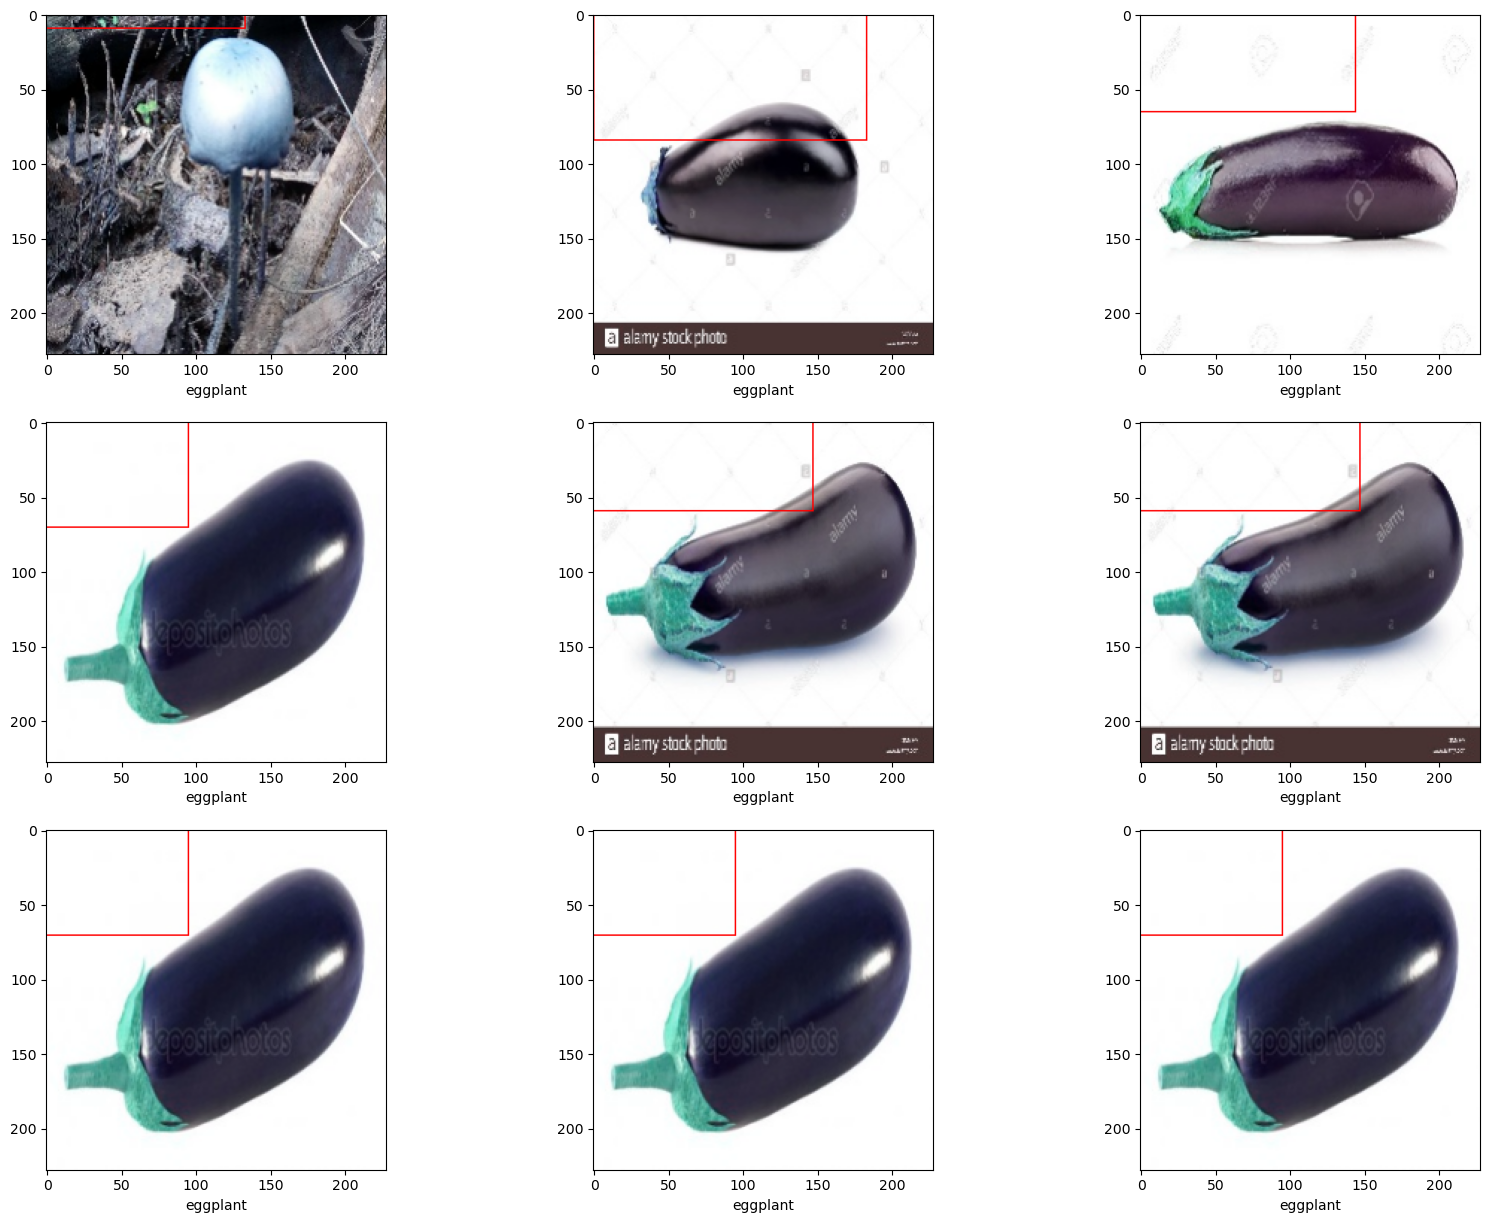

In [39]:
fig = plt.figure(figsize=(20,15))

for i in range(9):
    r = random.randint(1,10)
    plt.subplot(3,3,i+1)
    drawbox(model,X_test[r], Y_test[r], encoder)    
plt.show()

In [2]:
import tensorflow as tf

In [62]:
model.save("m1.h5")

In [ ]:
rmodel = tf.keras.models.load_model("m1.h5", custom_objects={ 'loss': custom_loss(y_true, y_pred) })

In [4]:
rmodel = tf.keras.models.load_model("new_model.h5", compile=False)

In [8]:
# fig = plt.figure(figsize=(20,15))

# for i in range(9):
#     r = random.randint(1,10)
#     plt.subplot(3,3,i+1)
#     drawbox(rmodel,X_test[r], Y_test[r], encoder)    
# plt.show()

In [9]:
import matplotlib.pyplot as plt

In [18]:
imgd = plt.imread("cucumber_2.jpg")

In [48]:
image = cv2.resize(cv2.imread("cucumber_2.jpg"), (228,228))
imgd = np.array(image)

In [49]:
predictimg = X_test[0]
predictimg = imgd

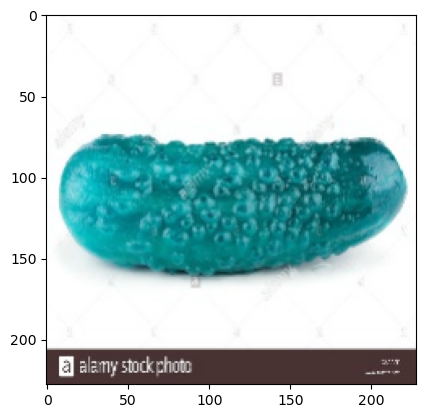

In [50]:
plt.imshow(predictimg)

In [51]:
# drawbox(rmodel,predictimg, Y_test[r], encoder)  

In [52]:
predictimg.shape

(228, 228, 3)

In [53]:
Y_test[0]

array([0.11403509, 0.19736842, 0.8245614 , 0.87719298, 0.        ,
       1.        , 0.        ])

In [54]:
def predictDrawbox(model,image, le):
    img = tf.cast(np.expand_dims(image, axis=0), tf.float32)
    
    #prediction
    predict = model.predict(img)
    
    pred_box = predict[...,0:4]*228
    
    x = pred_box[0][0]
    y = pred_box[0][1]
    w = pred_box[0][2]
    h = pred_box[0][3]
    #get class name
    trans= le.inverse_transform(predict[...,4:])
    
    im = PIL.Image.fromarray(image)
    draw=ImageDraw.Draw(im)
    draw.rectangle([x,y,w,h], outline='red')
    plt.xlabel(trans[0])
    plt.imshow(im)
    

1/1 [==============================] - 0s 200ms/step


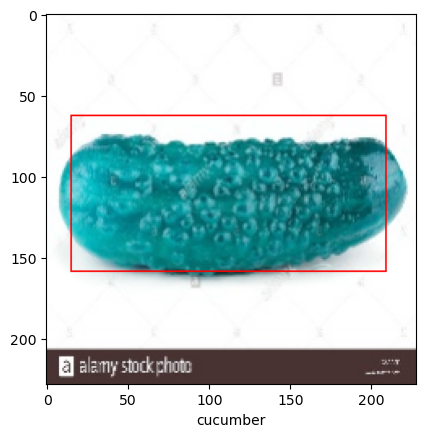

In [55]:
predictDrawbox(rmodel,predictimg,encoder)

In [72]:
# Open the file in binary mode
with open('file.pkl', 'rb') as file:
    # Call load method to deserialze
    labelbin = pickle.load(file)